# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


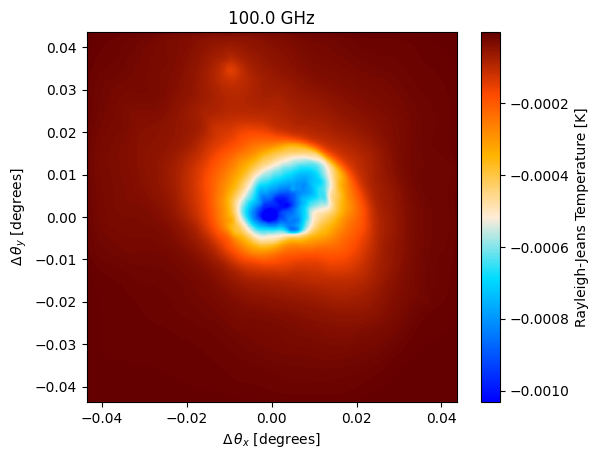

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

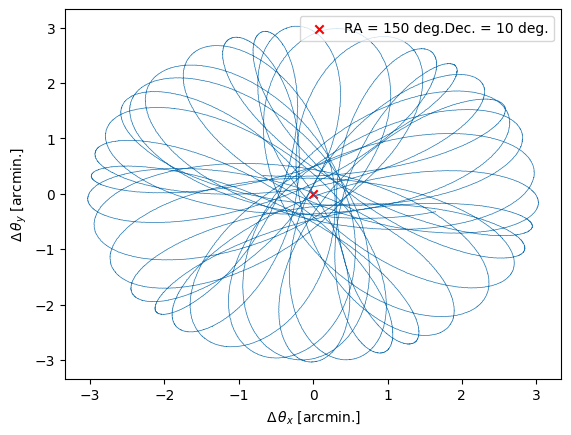

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                    # duration=60,
                    #   duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-17 15:53:38.256 INFO: Initialized base in 2311 ms.
Building atmosphere: 100%|██████████| 6/6 [00:04<00:00,  1.26it/s]
2024-10-17 15:53:44.407 INFO: Initialized atmosphere in 6136 ms.
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


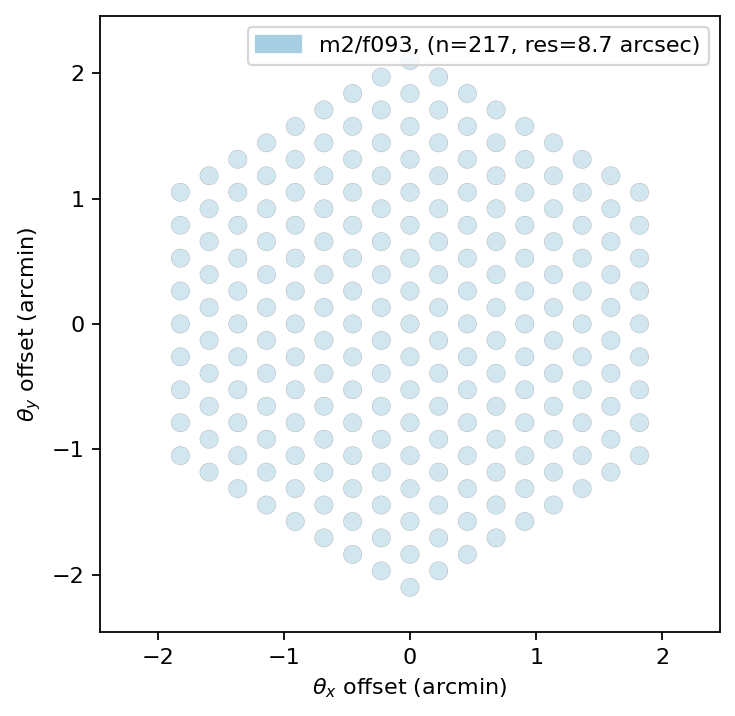

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.96073060e-04, -1.92557081e-04, -1.89849421e-04, ...,
         4.73255362e-04,  4.76551005e-04,  4.79192664e-04],
       [-2.45192194e-04, -2.41676350e-04, -2.38968772e-04, ...,
         4.27908737e-04,  4.31204274e-04,  4.33845781e-04],
       [-1.20882880e-04, -1.17366932e-04, -1.14659290e-04, ...,
         5.49133360e-04,  5.52428988e-04,  5.55070626e-04],
       ...,
       [ 1.21689853e-04,  1.25206942e-04,  1.27915276e-04, ...,
         7.60150308e-04,  7.63446812e-04,  7.66089710e-04],
       [-4.04641414e-04, -4.01124109e-04, -3.98415644e-04, ...,
         2.29004313e-04,  2.32300920e-04,  2.34943966e-04],
       [-7.45452422e-04, -7.41936529e-04, -7.39228920e-04, ...,
        -7.27058913e-05, -6.94103720e-05, -6.67688901e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


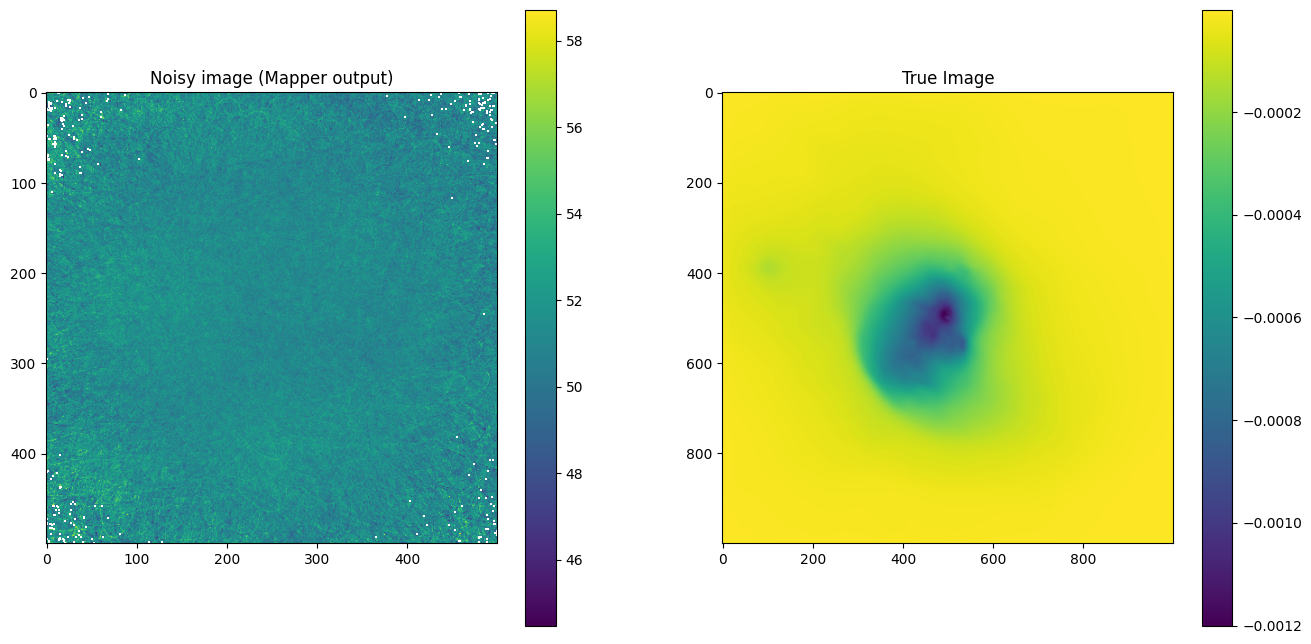

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-17 15:54:01.574 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-17 15:54:01.575 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Prepare noised input TODs:

Noise stddev: 0.00025144627518601016


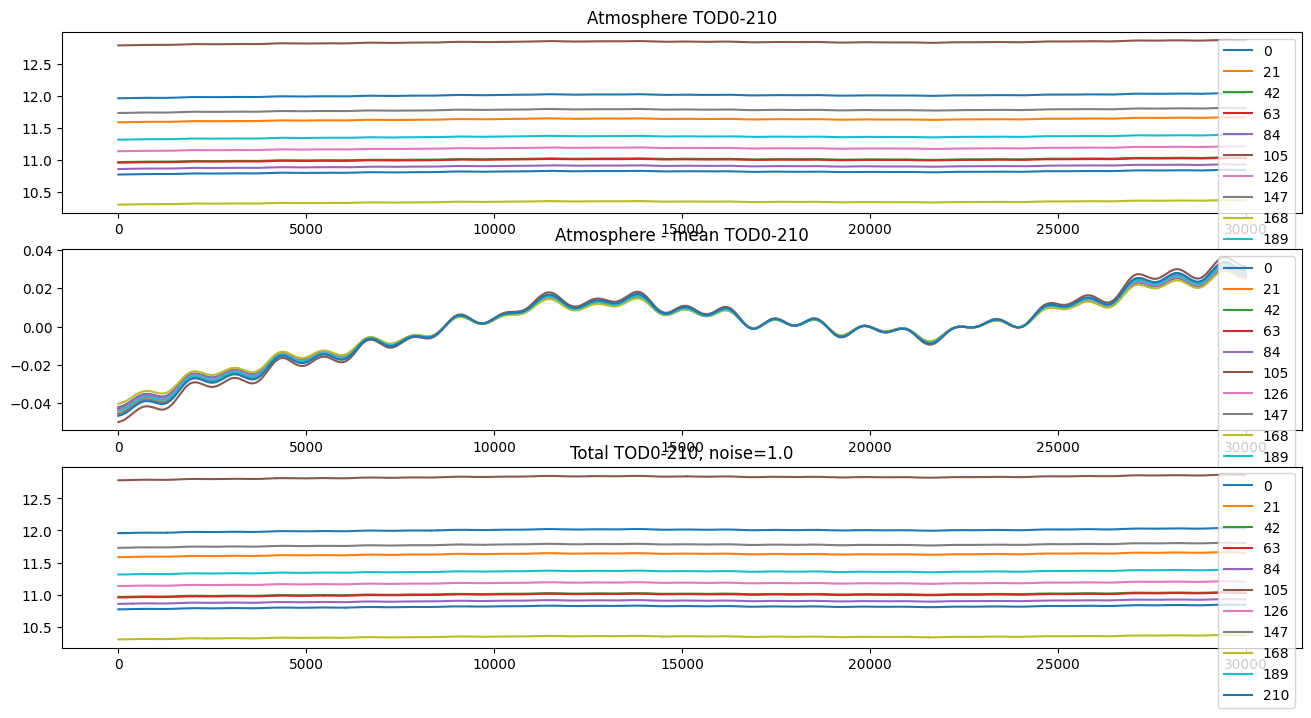

In [7]:
# Pick noise level for rest of run:
# noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
noiselevel = 1.0

jax_tods_atmos = tod_truthmap.get_field('atmosphere')

# Add n TODs for atmos:
# n = 1
# n = 2
# n = 10
# n = 100
n = jax_tods_atmos.shape[0]

# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

# noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.get_field('noise')*noiselevel)
# noised_jax_tod[:n] += np.float64(jax_tods_atmos[:n]) 
# # noised_jax_tod[:n] = np.float64(jax_tods_atmos[:n])

noised_jax_tod = np.float64(jax_tods_atmos)[:n] + np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]
denoised_jax_tod = noised_jax_tod - np.float64(tod_truthmap.get_field('noise')*noiselevel)[:n]

print("Noise stddev:", np.std(tod_truthmap.get_field('noise').compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(jax_tods_atmos[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos[i] - jax_tods_atmos[i].mean(), label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'Atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere - mean TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

# Next, initialise nifty prior model

Start with the atmosphere TOD model. For this, we need to re-write the CorrelatedFieldMaker:

In [8]:
import jax

import jax.numpy as jnp
import numpy as np
import nifty8.re as jft
import matplotlib.pyplot as plt

from functools import partial
from nifty8.re.correlated_field import Model, RegularCartesianGrid, hartley, HEALPixGrid, get_sht, ShapeWithDtype, random_like

key = jax.random.PRNGKey(42)

In [9]:
class CFM(jft.CorrelatedFieldMaker):
    def __init__(self, prefix):
        super().__init__(prefix)

    def finalize(self, n_fields: int = 0) -> Model:
        """Finishes off the model construction process and returns the
        constructed operator.
        """
        harmonic_transforms = []
        excitation_shape = ()
        for sgrid in self._target_grids:
            sub_shp = None
            sub_shp = sgrid.harmonic_grid.shape
            excitation_shape += sub_shp
            n = len(excitation_shape)
            harmonic_dvol = 1.0 / sgrid.total_volume
            if isinstance(sgrid, RegularCartesianGrid):
                axes = tuple(range(n - len(sub_shp), n))
                # TODO: Generalize to complex
                trafo = partial(hartley, axes=axes)
            elif isinstance(sgrid, HEALPixGrid):
                axis = len(excitation_shape) - 1
                trafo = get_sht(
                    nside=sgrid.nside,
                    axis=axis,
                    lmax=sgrid.harmonic_grid.lmax,
                    mmax=sgrid.harmonic_grid.mmax,
                    nthreads=1,
                )
            harmonic_transforms.append((harmonic_dvol, trafo))

        # Register the parameters for the excitations in harmonic space
        # TODO: actually account for the dtype here
        pfx = self._prefix + "xi"
        if n_fields > 0:
            xi_shape = (n_fields,) + excitation_shape
        else:
            xi_shape = excitation_shape
        self._parameter_tree[pfx] = ShapeWithDtype(xi_shape)

        def outer_harmonic_transform(p):
            harmonic_dvol, ht = harmonic_transforms[0]
            outer = harmonic_dvol * ht(p)
            for harmonic_dvol, ht in harmonic_transforms[1:]:
                outer = harmonic_dvol * ht(outer)
            return outer

        def _mk_expanded_amp(amp, sub_dom):  # Avoid late binding
            def expanded_amp(p):
                return amp(p)[sub_dom.harmonic_grid.power_distributor]

            return expanded_amp

        expanded_amplitudes = []
        namps = self.get_normalized_amplitudes()
        for amp, sgrid in zip(namps, self._target_grids):
            expanded_amplitudes.append(_mk_expanded_amp(amp, sgrid))

        def outer_amplitude(p):
            outer = expanded_amplitudes[0](p)
            for amp in expanded_amplitudes[1:]:
                # NOTE, the order is important here and must match with the
                # excitations
                # TODO, use functions instead and utilize numpy's casting
                outer = jnp.tensordot(outer, amp(p), axes=0)
            return outer

        def correlated_field(p):
            ea = outer_amplitude(p)
            cf_h = self.azm(p) * ea * p[self._prefix + "xi"]
            return self._offset_mean + outer_harmonic_transform(cf_h)
        
        p_dct = {k: 0 if 'xi' in k else None for k in self._parameter_tree}
        cfm_vmap = jax.vmap(correlated_field, in_axes=(p_dct,))

        init = {
            k: partial(random_like, primals=v) for k, v in self._parameter_tree.items()
        }
        cf = Model(cfm_vmap, domain=self._parameter_tree.copy(), init=init)
        cf.normalized_amplitudes = namps
        cf.target_grids = tuple(self._target_grids)
        return cf

In [10]:
# padding_atmos = 2000
# padding_atmos = 5000
padding_atmos = 10000
dims_atmos = ( (jax_tods_atmos.shape[1] + padding_atmos), )
# dims_atmos = ( (jax_tods_atmos.shape[1] - 200 + padding_atmos), )

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))
# cf_zm_tod = dict(offset_mean=jax_tods_atmos[0].mean().compute(), offset_std=(0.0005, 0.001))
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0002, 0.0001))
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.002, 0.001))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    # fluctuations=(0.005, 0.003), 
    # fluctuations=(0.001, 0.0005),
    fluctuations=(0.002, 0.001),
    # loglogavgslope=(-3, 0.5), 
    # loglogavgslope=(-2, 0.5), 
    loglogavgslope=(-2.5, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
# Custom CFM:
cfm_tod = CFM("combcf ")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
gp_tod = cfm_tod.finalize(n)
gp_tod

# Old: default CFM:
# cfm_tod = jft.CorrelatedFieldMaker("")
# cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
# cfm_tod.add_fluctuations(
#     dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
# )
# # init params for each TOD:
# gps_tods = []
# for i in range(n):
#     cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
#     # cfmi.set_amplitude_total_offset(**cf_zm_tod)
#     cfmi._azm = cfm_tod._azm
#     cfmi._offset_mean = cfm_tod._offset_mean
#     cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

#     cfmi._fluctuations.append(cfm_tod._fluctuations[0])
#     cfmi._target_grids.append(cfm_tod._target_grids[0])
#     cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
#     gps_tods.append(cfmi.finalize())
# gps_tods

Model(
	<function CFM.finalize.<locals>.correlated_field at 0x14b20c130f40>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x14b22d9fa480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x14b22d9fa480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x14b22d9fa480>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode': functools.partial(<function random_like at 0x1

# Define offset NormalPrior:

mean deviation: 7.888360318255961e-15
deviation std: 0.5961572175376351
offset for n dets: [-0.5014983  -0.31668651 -1.13390063 -0.44666644  0.64512908 -0.48310291
  0.94839564  0.11609337 -0.47325261 -0.85807603 -0.66579029  0.29540737
 -0.12755447  0.36284651  0.24435989  0.70127582 -0.5767597  -0.71008558
 -0.02142572 -0.24889829 -0.22514613  0.31482752 -0.7322605  -0.04433365
 -0.21899915  0.72270078 -0.45335122 -0.22280602  0.87937972 -1.05478076
 -0.46397081  0.65896207  0.33768044  0.95140277 -0.2063532  -0.2442731
  0.17720056 -0.60670159  0.48819797  0.28817901 -0.97510383  1.05626007
 -0.30727469  0.8077993  -0.58029629 -1.20410144 -0.00577527  0.70795374
 -0.88973346  0.65971546 -0.21363307 -1.17977978  0.26085324 -1.4209189
 -0.32258442 -0.85463622  0.19824308  0.56511357 -0.02063289 -0.07868915
 -0.40851127  0.52605467 -0.84282242 -0.31567925  0.1283135  -0.30836093
  0.79982121 -0.35572682  0.24905343  0.78917771 -0.2879924  -0.70091767
 -0.83319464  0.39270014 -0.1094846

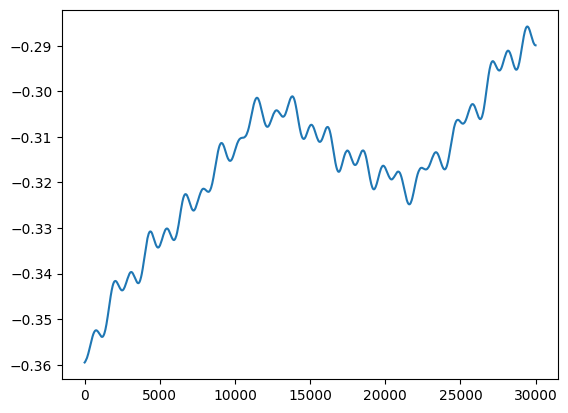

In [11]:
deviation = jax_tods_atmos - jax_tods_atmos.mean()

print("mean deviation:", deviation.mean().compute())
print("deviation std:", deviation.std().compute())

offset_tod = jnp.float64(deviation.mean(axis=1)[:n].compute())
print("offset for n dets:", offset_tod)

plt.plot(deviation[1])

In [12]:
offset_dict = dict(mean = 0.0, std = 0.6, shape=(n,))
offset_tod = jft.NormalPrior(**offset_dict, name='offset')

offset_tod

NormalPrior(
	<function wrap.<locals>.named_call at 0x14b20c1571a0>,
	domain={'offset': ShapeWithDtype(shape=(217,), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer({'offset': functools.partial(<function random_like at 0x14b22d9fa480>, primals=ShapeWithDtype(shape=(217,), dtype=<class 'jax.numpy.float64'>))})
)

# OLD Signal model:

In [13]:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods):
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

# signal_response_tod = Signal_TOD(gps_tods)

# CFM - TOD

In [14]:
class Signal_TOD(jft.Model):
    def __init__(self, gp_tod, offset_tod):
        self.gp_tod = gp_tod
        self.offset_tod = offset_tod
        super().__init__(init = self.gp_tod.init | self.offset_tod.init, domain = self.gp_tod.domain | self.offset_tod.domain )
        # super().__init__(init = self.gp_tod.init, domain = self.gp_tod.domain )
    
    def __call__(self, x):
        x_tod = {k: x[k] for k in x if 'comb' in k}
        res_tods = self.gp_tod(x_tod)
        # res_tods = self.gp_tod(x)

        return res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod(x)[:, jax.numpy.newaxis]
        # return res_tods[:, padding_atmos//2:-padding_atmos//2] + self.offset_tod[:, jax.numpy.newaxis]

signal_response_tod = Signal_TOD(gp_tod, offset_tod)

In [15]:
# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
print(noised_jax_tod.shape)
# truth = noised_jax_tod[:, 100:-100]
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


(217, 30000)


In [16]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'combcf tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'combcf xi': ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>),
	 'combcf zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'offset': ShapeWithDtype(shape=(217,), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'combcf tod fluctuations': functools.partial(<function random_like at 0x14b22d9fa480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf tod loglogavgslope': functools.partial(<function random_like at 0x14b22d9fa480>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'combcf xi': functools.partial(<function random_like at 0x14b22d9fa480>, primals=ShapeWithDtype(shape=(217, 40000), dtype=<class 'jax.numpy.float64'>)),
		 'combcf zeromode

# Draw Prior sample

(217, 30000)


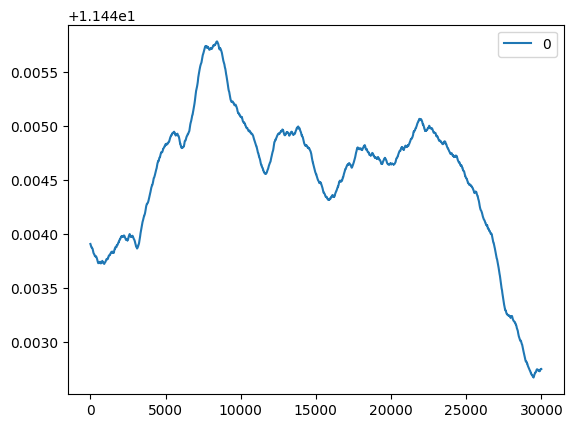

In [17]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
# for i in range(0, n, n//10):
for i in [0]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [18]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:8.779655e+03 ➽:8.680220e+02
M: Iteration 1 ⛰:+7.144343e+09 Δ⛰:3.877526e+13
M: →:0.125 ↺:False #∇²:12 |↘|:2.204544e+03 ➽:8.680220e+02
M: Iteration 2 ⛰:+6.022698e+09 Δ⛰:1.121645e+09
M: →:0.5 ↺:False #∇²:18 |↘|:9.990670e+03 ➽:8.680220e+02
M: Iteration 3 ⛰:+2.058685e+09 Δ⛰:3.964013e+09
M: →:1.0 ↺:False #∇²:24 |↘|:1.686060e+03 ➽:8.680220e+02
M: Iteration 4 ⛰:+7.148232e+08 Δ⛰:1.343862e+09
M: →:1.0 ↺:False #∇²:30 |↘|:7.431213e+02 ➽:8.680220e+02
M: Iteration 5 ⛰:+4.749712e+08 Δ⛰:2.398521e+08
OPTIMIZE_KL: Iteration 0001 ⛰:+4.7497e+08
OPTIMIZE_KL: #(KL minimization steps) 5
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 1.4e+02±     0.0, avg:    +0.21±     0.0, #dof:6510000'

OPTIMIZE_KL: Prior residual(s):
combcf tod fluctuations :: 'reduced χ²:    0.35±     0.0, avg:    +0.59±     0.0, #dof:      1'
combcf tod loglogavgslope:: 'reduced χ²:     1.5±     0.0, avg:     +1.2±     0.0, #dof:      1'
combcf xi               :: 'reduced χ²:   

In [19]:
samples.pos

Vector(
	{'combcf tod fluctuations': Array(0.59206476, dtype=float64),
	 'combcf tod loglogavgslope': Array(1.21548246, dtype=float64),
	 'combcf xi': Array([[-0.36589811,  3.29989429, 13.09412346, ..., -1.01166834,
	        -8.90569474, -7.58636377],
	       [ 1.75105663,  3.68359011, 13.80247256, ..., -0.75391406,
	        -8.66235896, -7.42161933],
	       [ 0.99464275,  3.06808379, 12.48352679, ..., -1.58943025,
	        -8.75031653, -7.07882637],
	       ...,
	       [-1.55875041,  3.5817458 , 13.95336826, ..., -1.05539959,
	        -9.90985127, -8.27333563],
	       [-0.25896981,  4.04779809, 14.59151597, ..., -1.31116435,
	        -8.97217712, -7.38917766],
	       [-1.33732098,  4.3307504 , 14.91898141, ...,  0.16080865,
	        -8.17140574, -7.42425856]], dtype=float64),
	 'combcf zeromode': Array(-1.34033752, dtype=float64),
	 'offset': Array([-0.83793625, -0.52957485, -1.89199131, -0.74627703,  1.07308368,
	       -0.8067458 ,  1.5779063 ,  0.1918034 , -0.79058242, -1.43201

In [20]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    # NEW model:
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['combcf tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['combcf tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['combcf zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")
    # OLD model:
    # print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    # print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    # print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # offset per detector:
    offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
    print(f"\toffset: ({offset_results.mean()}, {offset_results.std()}), {offset_dict['mean']}, {offset_dict['std']}")
    # residual offset:
    offset_residuals = offset_results - jnp.float64(deviation.mean(axis=1)[:n].compute())
    print(f"\toffset residuals: ({offset_residuals.mean()}, {offset_residuals.std()})")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.002366129233501085, 0.002, 0.001
	loglogvarslope: -1.8922587716691845, -2.5, 0.5
	zeromode std (LogNormal): 9.497331720763832e-05, 0.0002, 0.0001
	offset: (-0.0011024986001349673, 0.5959170871602008), 0.0, 0.6
	offset residuals: (-0.0011024986001473515, 0.0003886108485265586)


(217, 30000)


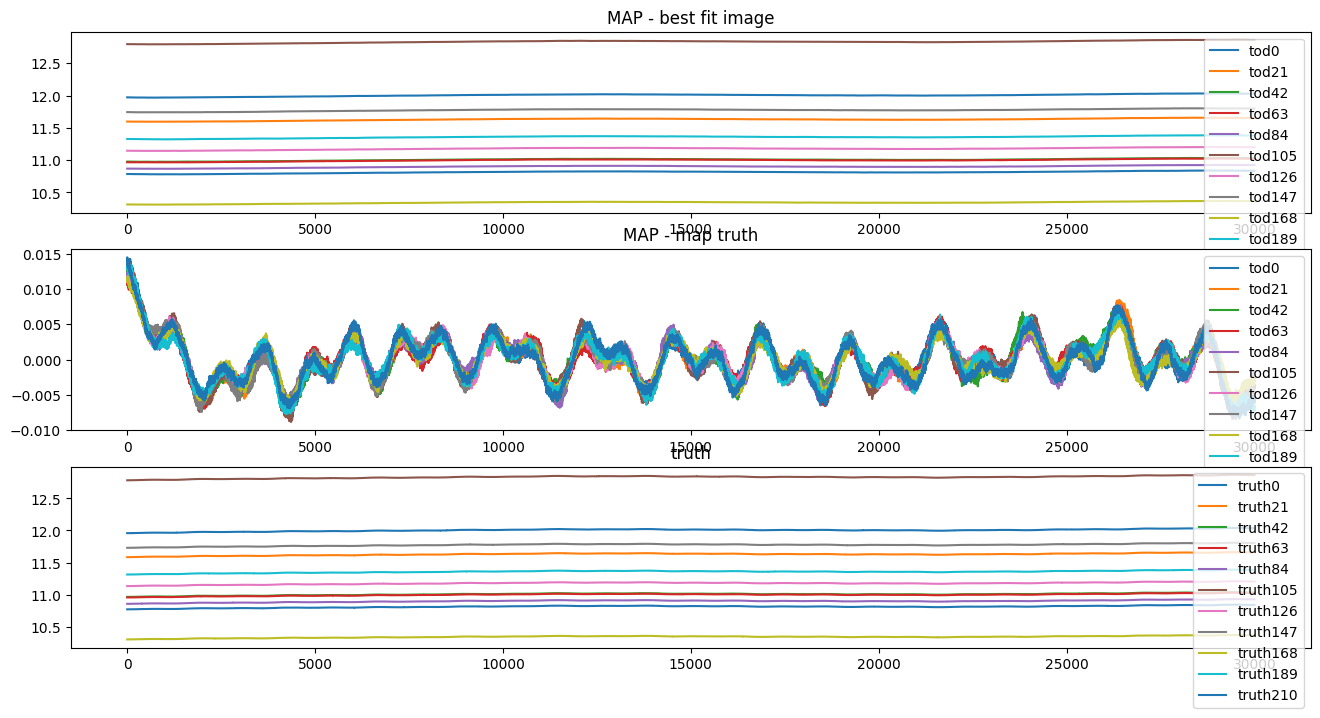

In [21]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in range(0, n, n//10 if n//10 != 0 else 1):
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

In [22]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+1.8842e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+1.4080e+08 Δ⛰:1.8842e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+8.0568e+07 Δ⛰:6.0230e+07 ➽:8.6802e+01
SL: Iteration 3 ⛰:+7.8987e+07 Δ⛰:1.5809e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+5.3042e+07 Δ⛰:2.5945e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+5.2628e+07 Δ⛰:4.1416e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+1.5287e+07 Δ⛰:3.7341e+07 ➽:8.6802e+01
SL: Iteration 7 ⛰:+1.5287e+07 Δ⛰:1.7963e+02 ➽:8.6802e+01
SL: Iteration 8 ⛰:+7.9410e+06 Δ⛰:7.3460e+06 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.0468e+06 Δ⛰:5.8941e+06 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.0468e+06 Δ⛰:1.5238e+00 ➽:8.6802e+01
SL: Iteration 0 ⛰:+1.5692e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+9.9532e+07 Δ⛰:1.5692e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+8.9641e+07 Δ⛰:9.8912e+06 ➽:8.6802e+01
SL: Iteration 3 ⛰:+8.4068e+07 Δ⛰:5.5735e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+3.4134e+07 Δ⛰:4.9934e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.7753e+07 Δ⛰:1.6380e+07 ➽:8.6802e+01
SL: Iteration 6 ⛰

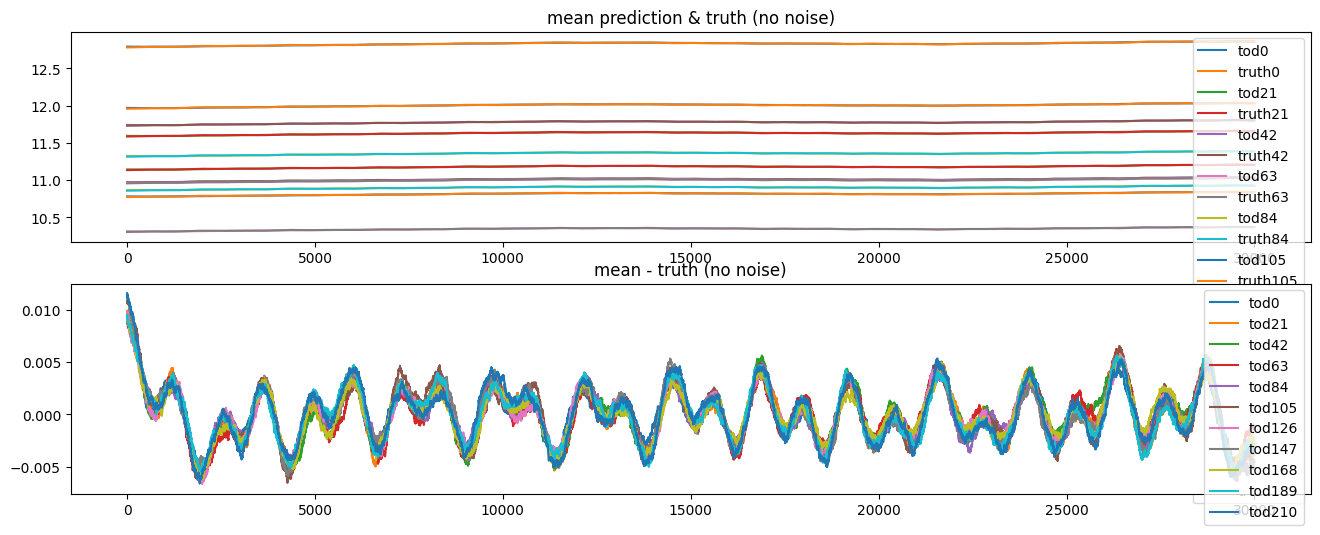

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+1.8824e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+2.5604e+08 Δ⛰:1.8823e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.5378e+08 Δ⛰:2.2609e+06 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.3418e+08 Δ⛰:1.9595e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.7910e+08 Δ⛰:5.5079e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.7894e+08 Δ⛰:1.6353e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+6.0078e+07 Δ⛰:1.1886e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+3.8948e+07 Δ⛰:2.1130e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.8514e+07 Δ⛰:4.3449e+05 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.4209e+07 Δ⛰:1.4305e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.4209e+07 Δ⛰:3.8558e+01 ➽:8.6802e+01
SL: Iteration 0 ⛰:+1.7350e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+4.1116e+09 Δ⛰:1.7346e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.2104e+08 Δ⛰:3.8906e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.1200e+08 Δ⛰:9.0369e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.8171e+08 Δ⛰:3.0292e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.7791e+08 Δ⛰:3.8058e+06 ➽:8.6802e+01
SL: Iteration 6 ⛰

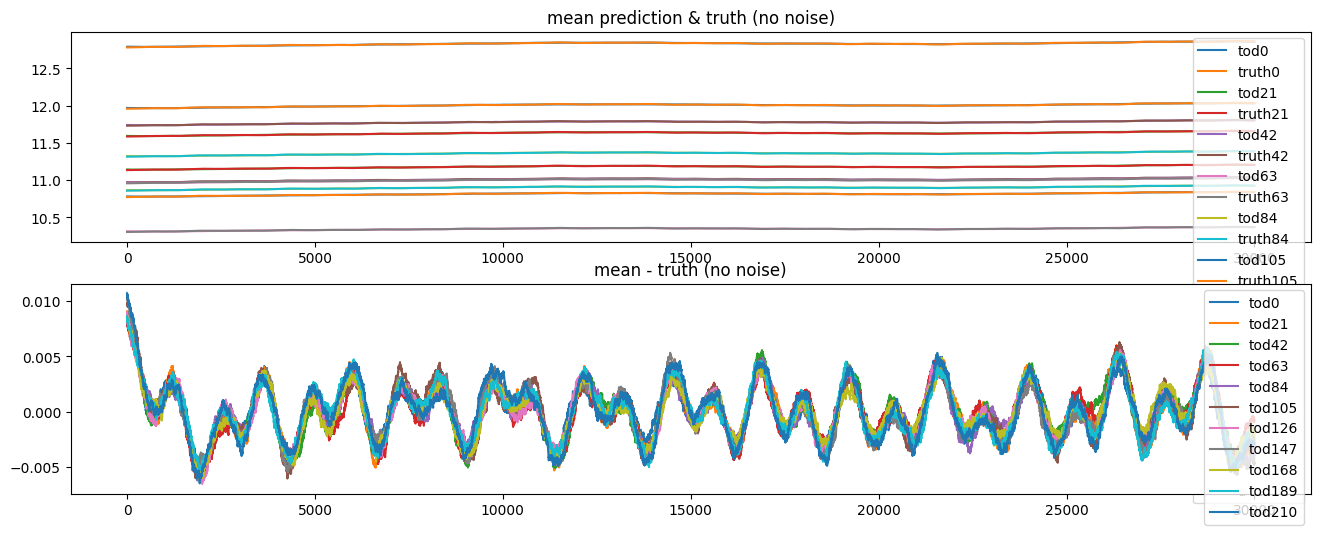

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+1.9916e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+4.6809e+08 Δ⛰:1.9915e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.3300e+08 Δ⛰:2.3509e+08 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.3189e+08 Δ⛰:1.1139e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.8538e+08 Δ⛰:4.6505e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.8520e+08 Δ⛰:1.8602e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+6.5514e+07 Δ⛰:1.1968e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+6.0445e+07 Δ⛰:5.0688e+06 ➽:8.6802e+01
SL: Iteration 8 ⛰:+4.2084e+07 Δ⛰:1.8362e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.6942e+07 Δ⛰:1.5142e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.6928e+07 Δ⛰:1.4632e+04 ➽:8.6802e+01
SL: Iteration 11 ⛰:+2.6928e+07 Δ⛰:1.2692e+02 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.7504e+07 Δ⛰:9.4235e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.7504e+07 Δ⛰:2.8798e+01 ➽:8.6802e+01
SL: Iteration 0 ⛰:+1.6402e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+3.0565e+08 Δ⛰:1.6401e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.0881e+08 Δ⛰:9.6848e+07 ➽:8.6802e+01
SL: Iteration 

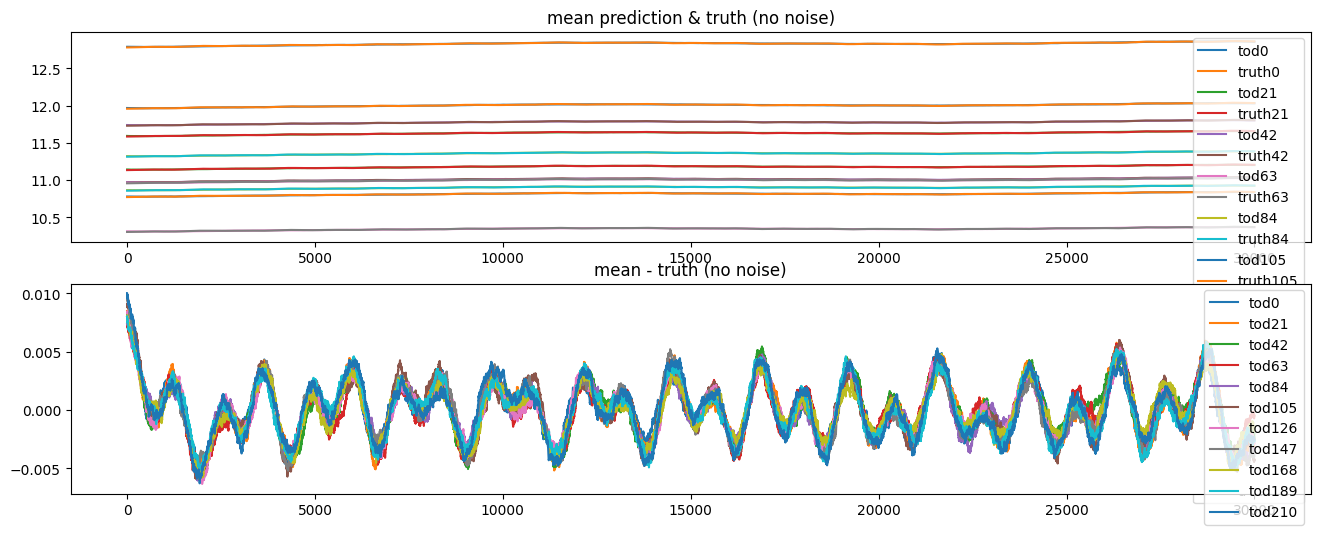

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+1.9231e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+1.1232e+09 Δ⛰:1.9230e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+3.0225e+08 Δ⛰:8.2091e+08 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.8845e+08 Δ⛰:1.3796e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.7772e+08 Δ⛰:1.1073e+08 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.7724e+08 Δ⛰:4.8040e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+6.3926e+07 Δ⛰:1.1331e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.6980e+07 Δ⛰:1.6946e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+4.1251e+07 Δ⛰:5.7294e+06 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.6935e+07 Δ⛰:1.4316e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.6918e+07 Δ⛰:1.7106e+04 ➽:8.6802e+01
SL: Iteration 11 ⛰:+2.6883e+07 Δ⛰:3.4652e+04 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.7707e+07 Δ⛰:9.1762e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.7707e+07 Δ⛰:1.3449e+01 ➽:8.6802e+01
SL: Iteration 0 ⛰:+1.9965e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+2.9063e+09 Δ⛰:1.9962e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+1.7645e+08 Δ⛰:2.7298e+09 ➽:8.6802e+01
SL: Iteration 

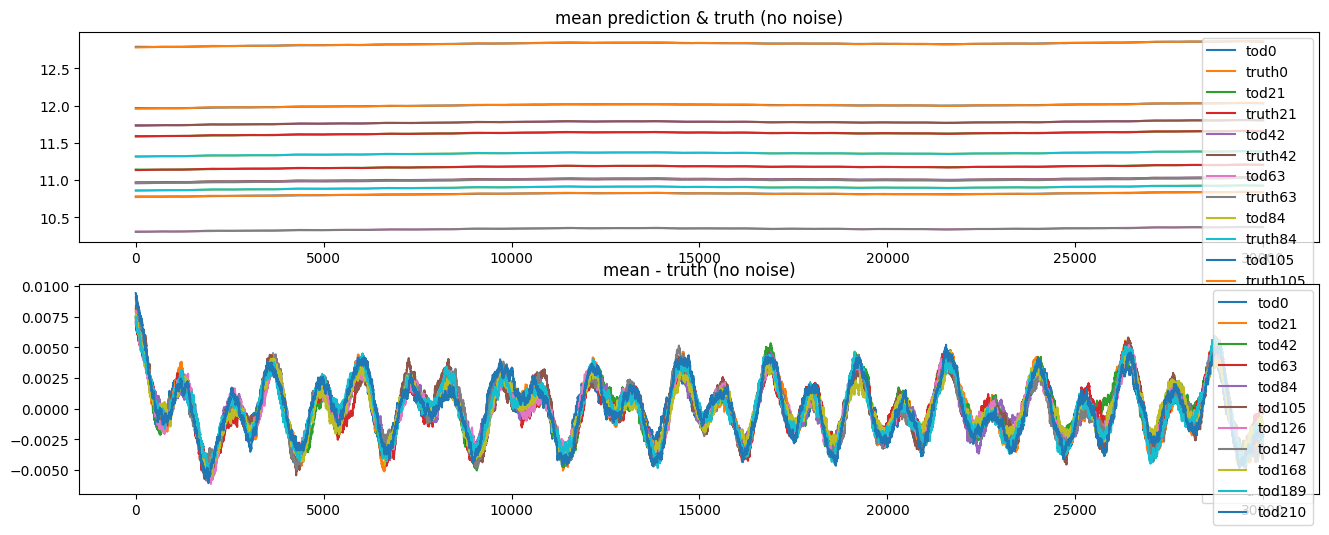

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+2.2419e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+8.8898e+09 Δ⛰:2.2410e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.4331e+08 Δ⛰:8.6465e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.0766e+08 Δ⛰:3.5653e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.9394e+08 Δ⛰:1.3721e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.9381e+08 Δ⛰:1.2940e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+7.1749e+07 Δ⛰:1.2206e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+6.8568e+07 Δ⛰:3.1803e+06 ➽:8.6802e+01
SL: Iteration 8 ⛰:+4.5207e+07 Δ⛰:2.3362e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+3.2323e+07 Δ⛰:1.2884e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.8711e+07 Δ⛰:3.6125e+06 ➽:8.6802e+01
SL: Iteration 11 ⛰:+2.8664e+07 Δ⛰:4.6881e+04 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.8768e+07 Δ⛰:9.8954e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.8768e+07 Δ⛰:8.8812e+01 ➽:8.6802e+01
SL: Iteration 14 ⛰:+1.8761e+07 Δ⛰:7.5014e+03 ➽:8.6802e+01
SL: Iteration 15 ⛰:+1.3915e+07 Δ⛰:4.8453e+06 ➽:8.6802e+01
SL: Iteration 16 ⛰:+1.3913e+07 Δ⛰:2.3053e+03 ➽:8.6802e+01
SL: 

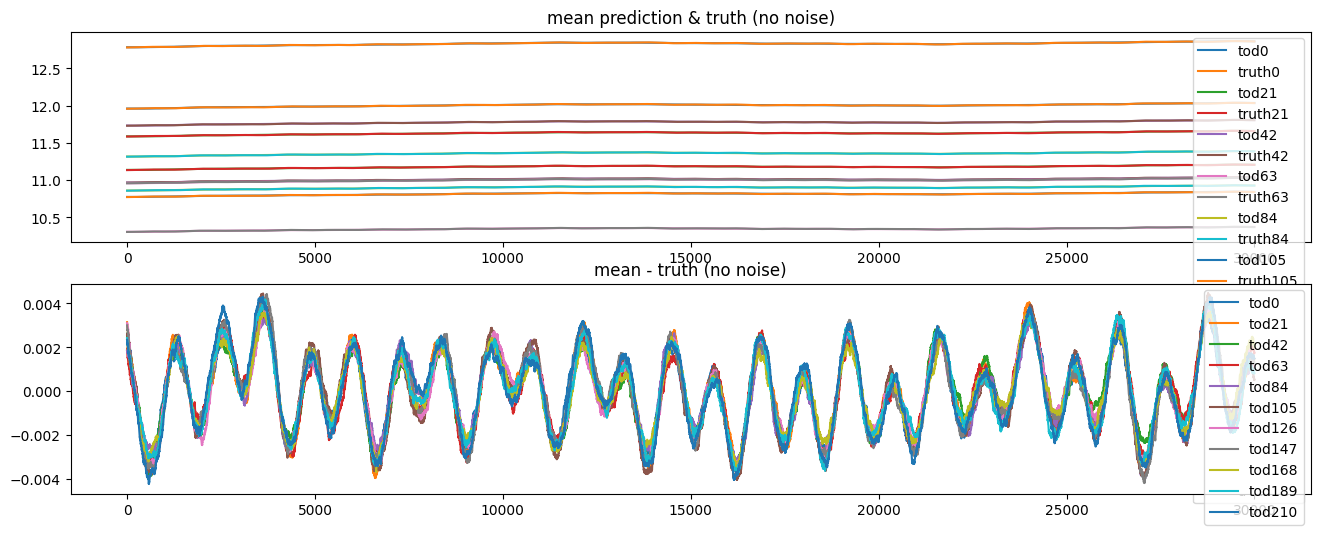

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+1.8513e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+7.6480e+08 Δ⛰:1.8512e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.7391e+08 Δ⛰:4.9089e+08 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.7264e+08 Δ⛰:1.2646e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+2.1778e+08 Δ⛰:5.4860e+07 ➽:8.6802e+01
SL: Iteration 5 ⛰:+2.1744e+08 Δ⛰:3.4312e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+6.2122e+07 Δ⛰:1.5532e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.8247e+07 Δ⛰:1.3875e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.7171e+07 Δ⛰:1.1076e+07 ➽:8.6802e+01
SL: Iteration 9 ⛰:+1.9338e+07 Δ⛰:1.7833e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+1.9311e+07 Δ⛰:2.7430e+04 ➽:8.6802e+01
SL: Iteration 11 ⛰:+1.9310e+07 Δ⛰:1.3732e+02 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.0671e+07 Δ⛰:8.6391e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.0671e+07 Δ⛰:5.8772e+00 ➽:8.6802e+01
SL: Iteration 0 ⛰:+1.6434e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+2.0439e+09 Δ⛰:1.6432e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+5.6408e+08 Δ⛰:1.4798e+09 ➽:8.6802e+01
SL: Iteration 

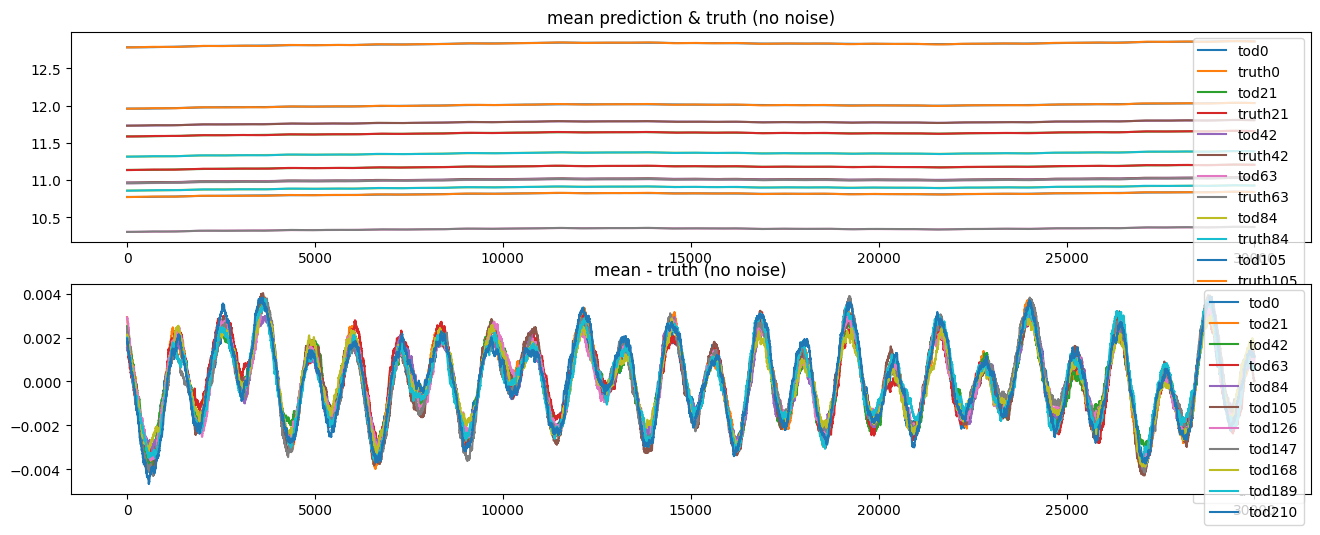

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+1.4239e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+2.4560e+09 Δ⛰:1.4236e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+7.2946e+08 Δ⛰:1.7265e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+7.2163e+08 Δ⛰:7.8288e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+2.0654e+08 Δ⛰:5.1509e+08 ➽:8.6802e+01
SL: Iteration 5 ⛰:+2.0512e+08 Δ⛰:1.4217e+06 ➽:8.6802e+01
SL: Iteration 6 ⛰:+6.1666e+07 Δ⛰:1.4346e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.0814e+07 Δ⛰:2.0852e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+3.7376e+07 Δ⛰:3.4382e+06 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.0958e+07 Δ⛰:1.6418e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+1.9987e+07 Δ⛰:9.7100e+05 ➽:8.6802e+01
SL: Iteration 11 ⛰:+1.9987e+07 Δ⛰:5.0151e+01 ➽:8.6802e+01
SL: Iteration 0 ⛰:+1.5937e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+2.1064e+08 Δ⛰:1.5937e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+2.1053e+08 Δ⛰:1.0972e+05 ➽:8.6802e+01
SL: Iteration 3 ⛰:+2.1003e+08 Δ⛰:5.0210e+05 ➽:8.6802e+01
SL: Iteration 4 ⛰:+2.0909e+08 Δ⛰:9.4157e+05 ➽:8.6802e+01
SL: Iteration 5 

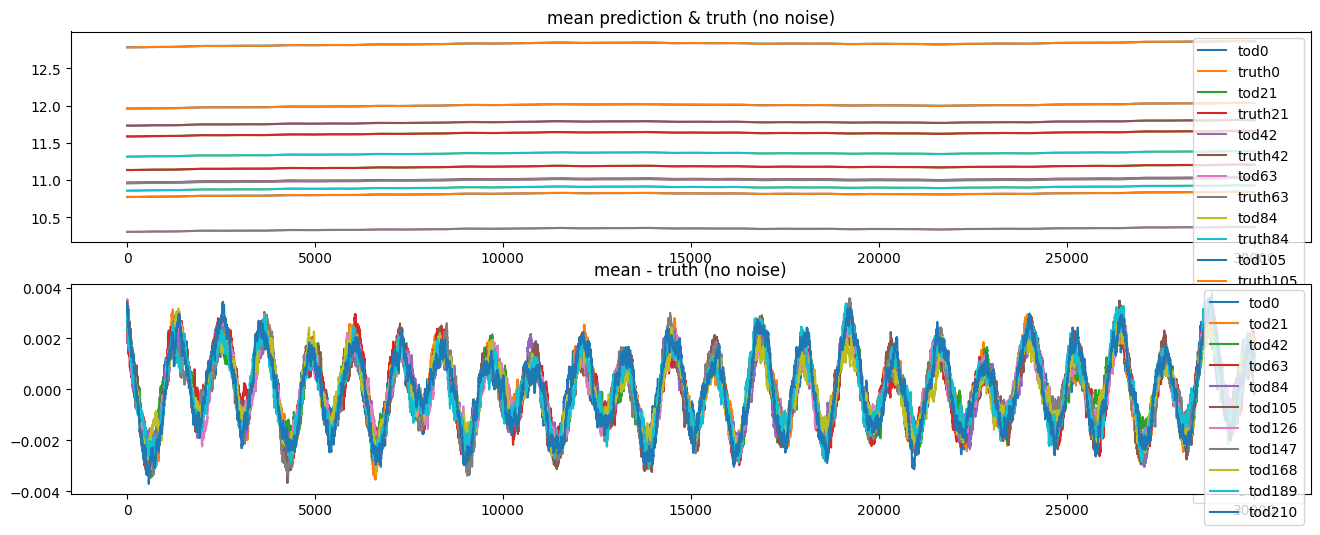

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:+1.9000e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+7.9373e+09 Δ⛰:1.8993e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+3.0758e+08 Δ⛰:7.6297e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+3.0518e+08 Δ⛰:2.4042e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+1.9844e+08 Δ⛰:1.0674e+08 ➽:8.6802e+01
SL: Iteration 5 ⛰:+1.9738e+08 Δ⛰:1.0614e+06 ➽:8.6802e+01
SL: Iteration 6 ⛰:+6.5982e+07 Δ⛰:1.3140e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.4174e+07 Δ⛰:2.1808e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+4.3264e+07 Δ⛰:9.0998e+05 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.9029e+07 Δ⛰:1.4235e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.6830e+07 Δ⛰:2.1996e+06 ➽:8.6802e+01
SL: Iteration 11 ⛰:+2.6829e+07 Δ⛰:2.3636e+02 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.7267e+07 Δ⛰:9.5628e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.7267e+07 Δ⛰:1.2858e+01 ➽:8.6802e+01
SL: Iteration 0 ⛰:+1.7668e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+6.6097e+09 Δ⛰:1.7662e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+3.7382e+08 Δ⛰:6.2358e+09 ➽:8.6802e+01
SL: Iteration 

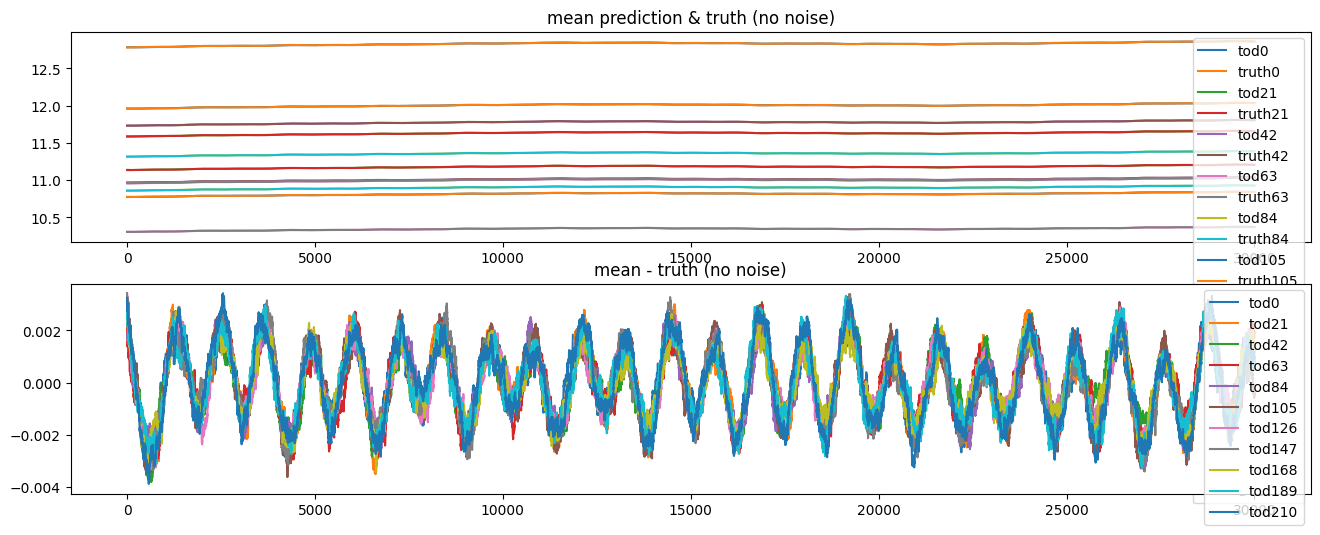

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+1.6485e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+4.5812e+09 Δ⛰:1.6481e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+9.6775e+08 Δ⛰:3.6135e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+9.5755e+08 Δ⛰:1.0198e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+2.1578e+08 Δ⛰:7.4178e+08 ➽:8.6802e+01
SL: Iteration 5 ⛰:+2.1487e+08 Δ⛰:9.1200e+05 ➽:8.6802e+01
SL: Iteration 6 ⛰:+7.2171e+07 Δ⛰:1.4270e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.9736e+07 Δ⛰:2.2435e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+4.5474e+07 Δ⛰:4.2624e+06 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.9260e+07 Δ⛰:1.6214e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.7979e+07 Δ⛰:1.2812e+06 ➽:8.6802e+01
SL: Iteration 11 ⛰:+2.7975e+07 Δ⛰:3.6941e+03 ➽:8.6802e+01
SL: Iteration 12 ⛰:+1.8144e+07 Δ⛰:9.8307e+06 ➽:8.6802e+01
SL: Iteration 13 ⛰:+1.8139e+07 Δ⛰:5.6711e+03 ➽:8.6802e+01
SL: Iteration 14 ⛰:+1.8091e+07 Δ⛰:4.7530e+04 ➽:8.6802e+01
SL: Iteration 15 ⛰:+1.4946e+07 Δ⛰:3.1449e+06 ➽:8.6802e+01
SL: Iteration 16 ⛰:+1.4946e+07 Δ⛰:1.8856e+01 ➽:8.6802e+01
SL: 

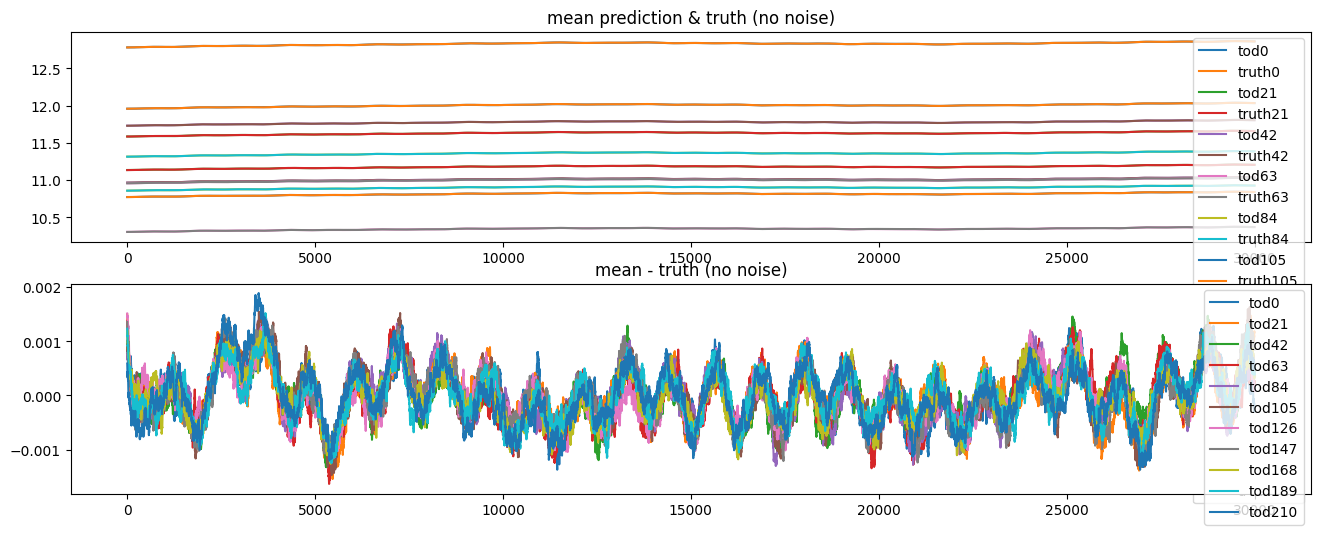

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:+1.9230e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+7.9700e+09 Δ⛰:1.9222e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+1.1839e+09 Δ⛰:6.7862e+09 ➽:8.6802e+01
SL: Iteration 3 ⛰:+1.1696e+09 Δ⛰:1.4267e+07 ➽:8.6802e+01
SL: Iteration 4 ⛰:+2.5295e+08 Δ⛰:9.1665e+08 ➽:8.6802e+01
SL: Iteration 5 ⛰:+2.4878e+08 Δ⛰:4.1646e+06 ➽:8.6802e+01
SL: Iteration 6 ⛰:+7.0430e+07 Δ⛰:1.7835e+08 ➽:8.6802e+01
SL: Iteration 7 ⛰:+4.7649e+07 Δ⛰:2.2781e+07 ➽:8.6802e+01
SL: Iteration 8 ⛰:+4.2943e+07 Δ⛰:4.7062e+06 ➽:8.6802e+01
SL: Iteration 9 ⛰:+2.2693e+07 Δ⛰:2.0250e+07 ➽:8.6802e+01
SL: Iteration 10 ⛰:+2.2692e+07 Δ⛰:1.0529e+03 ➽:8.6802e+01
SL: Iteration 11 ⛰:+2.2691e+07 Δ⛰:3.0079e+01 ➽:8.6802e+01
SL: Iteration 0 ⛰:+2.0344e+13 Δ⛰:inf ➽:8.6802e+01
SL: Iteration 1 ⛰:+8.0837e+08 Δ⛰:2.0343e+13 ➽:8.6802e+01
SL: Iteration 2 ⛰:+4.6707e+08 Δ⛰:3.4130e+08 ➽:8.6802e+01
SL: Iteration 3 ⛰:+4.6341e+08 Δ⛰:3.6536e+06 ➽:8.6802e+01
SL: Iteration 4 ⛰:+2.3977e+08 Δ⛰:2.2365e+08 ➽:8.6802e+01
SL: Iteration 5 

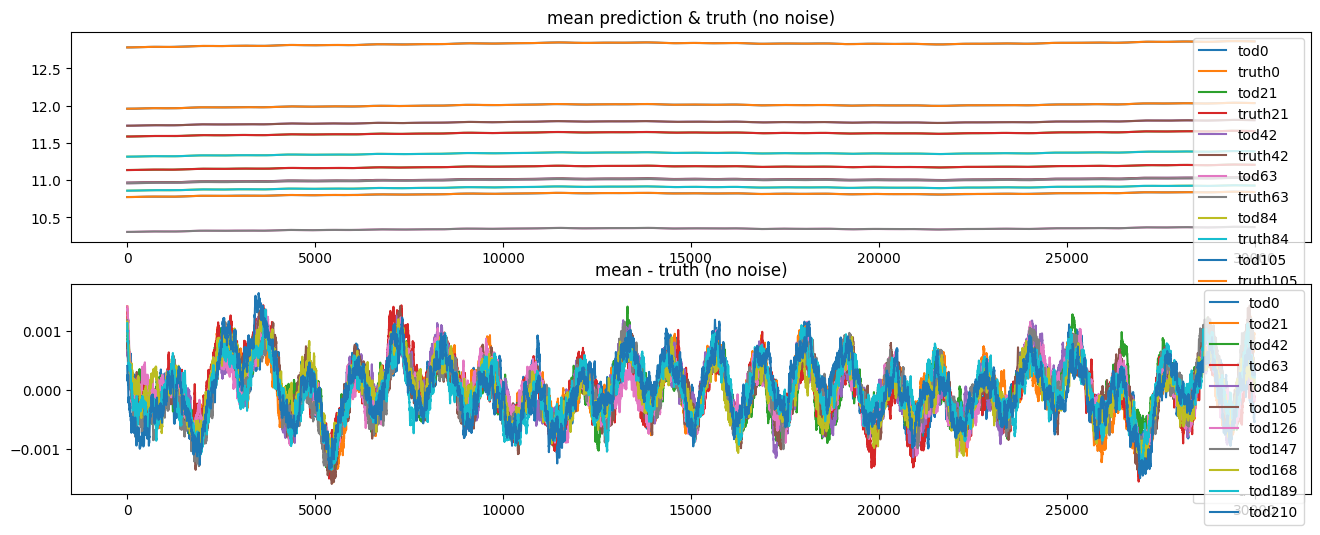

In [23]:
n_it = 10
# n_it = 30
# n_it = 50

if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    for i in range(0, n, n//10 if n//10 != 0 else 1):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(denoised_jax_tod[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i], label=f"tod{i}")
        # axes_tods[0].plot(denoised_jax_tod[i, 100:-100], label=f"truth{i}")
        # axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - denoised_jax_tod[i, 100:-100], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth (no noise)')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth (no noise)')
    axes_tods[1].legend()

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

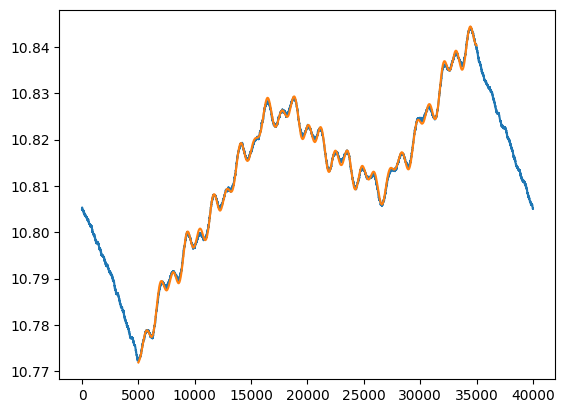

In [24]:
offset_results = jft.NormalPrior(**offset_dict)(samples.pos['offset'])
pred = gp_tod({k: samples.pos[k] for k in samples.pos if 'comb' in k}) + offset_results[0, np.newaxis]
padded_truth = np.pad(jax_tods_atmos[0], pad_width=padding_atmos//2, mode='constant', constant_values=np.nan)

plt.plot(pred[0])
plt.plot(padded_truth)

In [25]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.002252617315928589, 0.002, 0.001
	loglogvarslope: -2.0660361707915635, -2.5, 0.5
	zeromode std (LogNormal): 6.185669180090595e-05, 0.0002, 0.0001
	offset: (-0.0018864294165033266, 0.5958246196595425), 0.0, 0.6
	offset residuals: (-0.001886429416515709, 0.00030324021047601664)


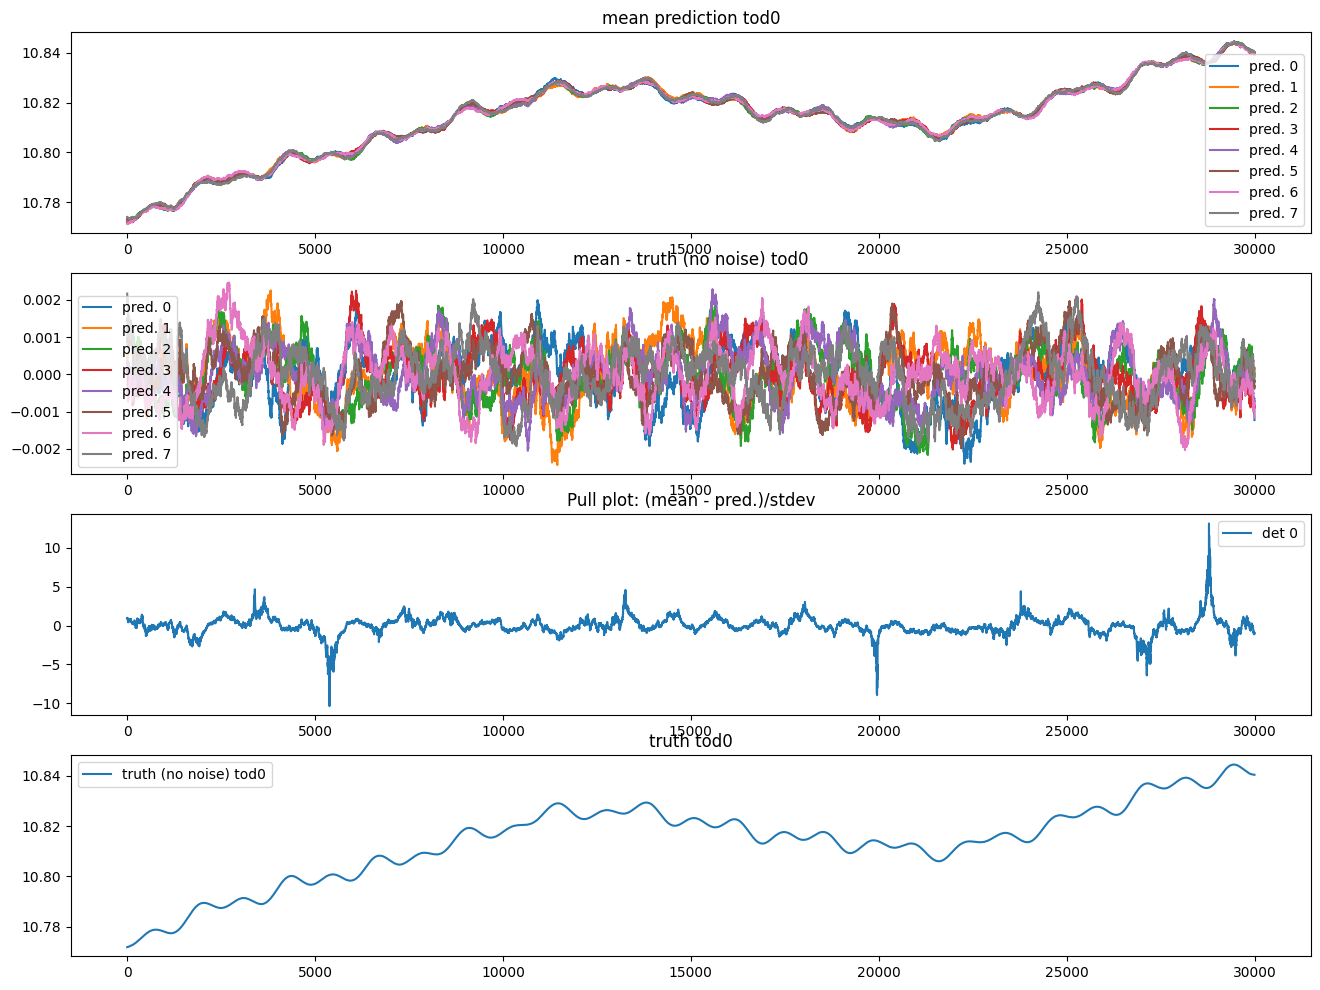

In [26]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()

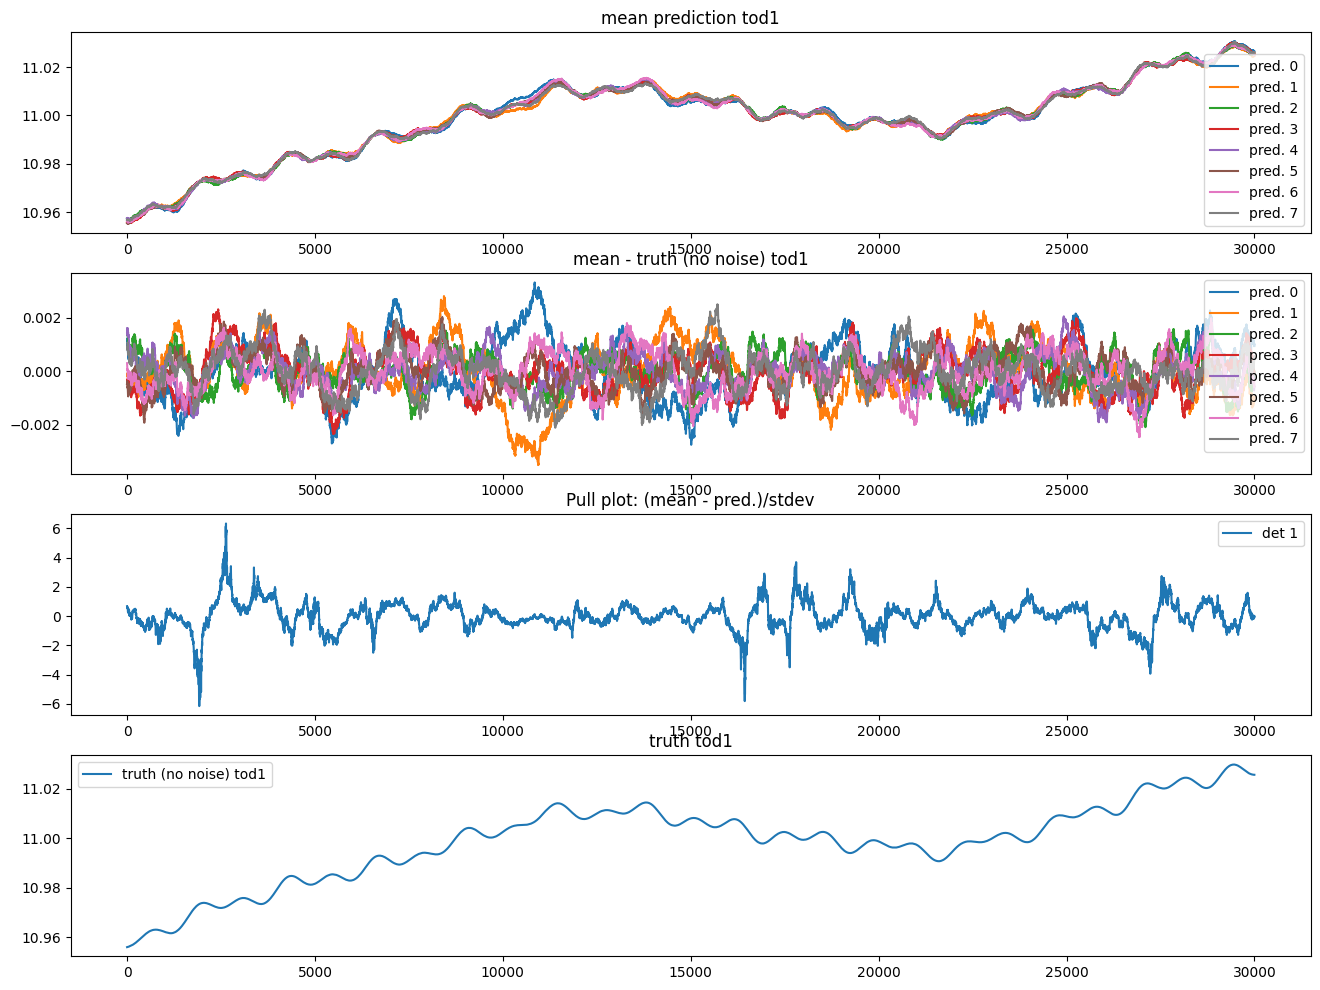

In [27]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 1 # TOD id
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i], label=f"pred. {j}")
    # im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - denoised_jax_tod[i, 100:-100], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i])/std[i], label=f"det {i}")
# im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - denoised_jax_tod[i, 100:-100])/std[i], label=f"det {i}")
im3 = axes[3].plot(denoised_jax_tod[i], label=f"truth (no noise) tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth (no noise) tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()